# Bike Sharing Data Set

## Project Overview

This project involves predicting bike rental counts (hourly and daily) based on environmental and seasonal factors. The dataset provides insights into how weather, season, and time affect bike-sharing rental behaviors. The objective is to leverage the dataset for exploratory data analysis, data visualization, and regression modeling, while uncovering key trends and relationships.

## Dataset Description

The dataset contains rental data for the **Capital Bikeshare system** spanning **2011 to 2012**. It includes the hourly and daily counts of rented bikes, along with corresponding weather and seasonal information. The data reflects how various factors such as weather conditions, precipitation, day of the week, season, and hour of the day influence bike rentals.

[Source: Bike Sharing Dataset](https://code.datasciencedojo.com/datasciencedojo/datasets/tree/master/Bike%20Sharing)

## Data Preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, VotingRegressor, StackingRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, LassoCV, Lasso, RidgeCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline, make_pipeline

import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor, OLSInfluence
from statsmodels.graphics.gofplots import qqplot

from scipy.stats import pearsonr

import warnings
warnings.filterwarnings('ignore')

In [2]:
def wrangle(path):
    df = pd.read_csv(path)
    df.drop(columns = ['instant', 'dteday'], inplace = True)

    return df

df = wrangle('day.csv')
df.head()

season  yr  mnth  holiday  weekday  workingday  weathersit      temp  \
0       1   0     1        0        6           0           2  0.344167   
1       1   0     1        0        0           0           2  0.363478   
2       1   0     1        0        1           1           1  0.196364   
3       1   0     1        0        2           1           1  0.200000   
4       1   0     1        0        3           1           1  0.226957   

      atemp       hum  windspeed  casual  registered   cnt  
0  0.363625  0.805833   0.160446     331         654   985  
1  0.353739  0.696087   0.248539     131         670   801  
2  0.189405  0.437273   0.248309     120        1229  1349  
3  0.212122  0.590435   0.160296     108        1454  1562  
4  0.229270  0.436957   0.186900      82        1518  1600

## Variable Selection and Feature Extraction (1)

In [3]:
# Select Target Variable and Predictor Variables
target = 'cnt'
features = df.select_dtypes("number").drop(columns = [target]).columns

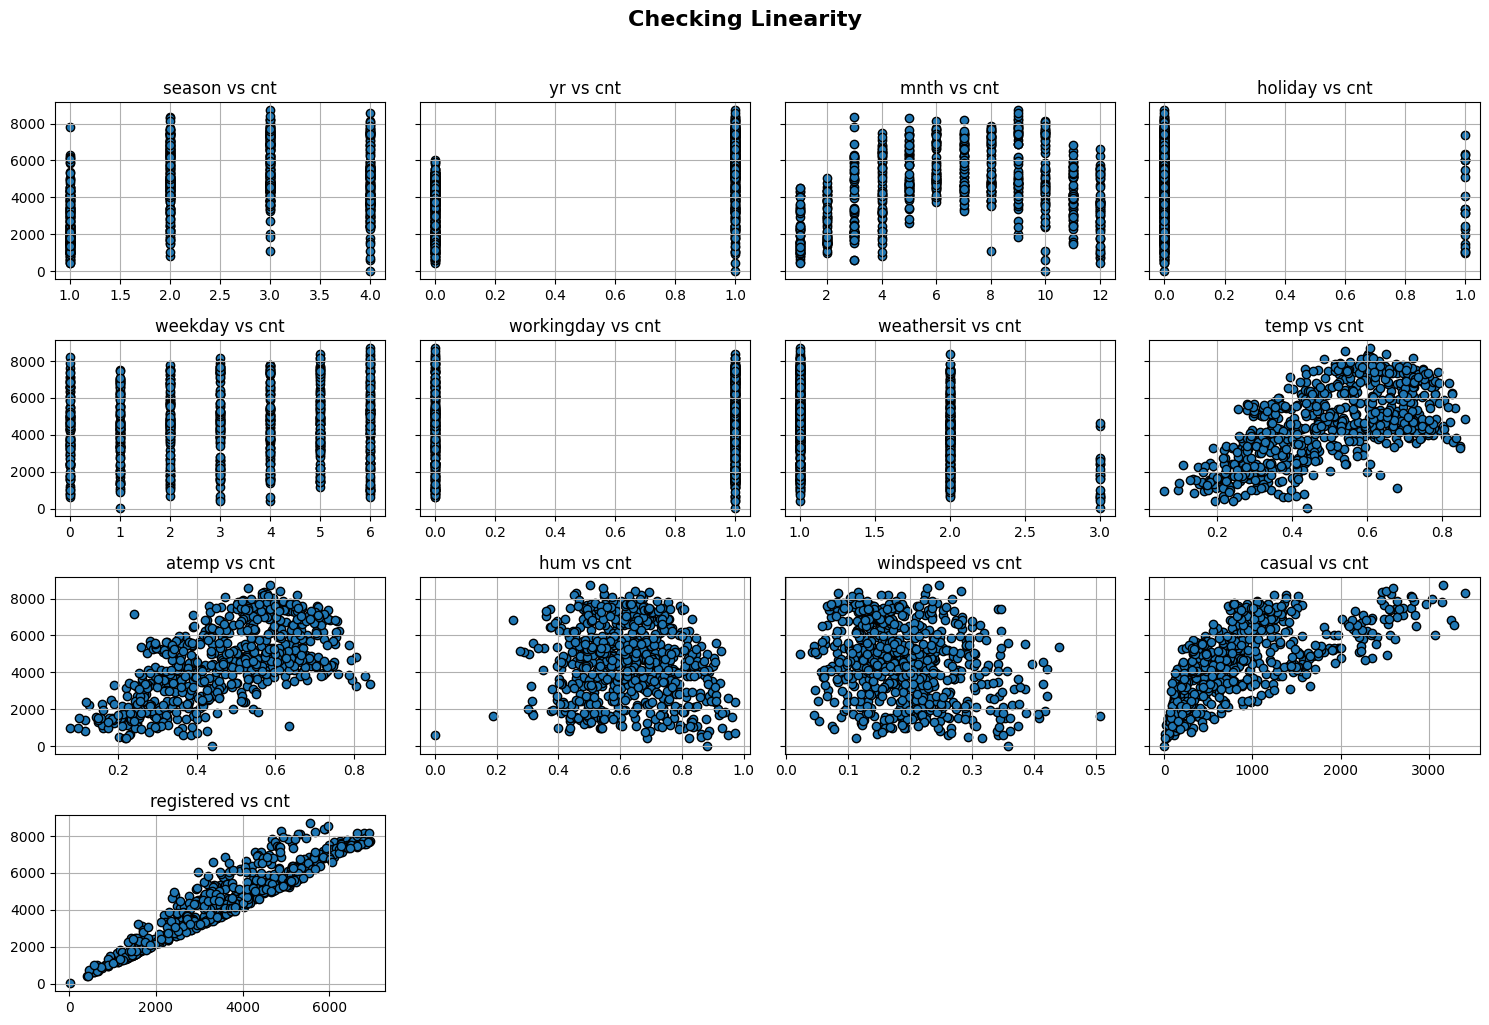

In [4]:
# Check Linearity in the Dataset
def check_linearity(df, target = 'cnt', features = features):
    """
    This function checks the linearity between the target variable and the selected features
    by plotting scatter plots for each feature against the target variable.

    Parameters:
    df (DataFrame): The DataFrame containing the data.
    target (str): The column name of the target variable (default is 'cnt').
    features (list): A list of feature column names to check against the target (default is 'features').

    Returns:
    fig, ax: The figure and axes objects for the plot.
    """
    fig, ax = plt.subplots(4, 4, figsize = (15, 10), sharey = True)
    ax = ax.flatten()  # ax.ravel()
    fig.suptitle("Checking Linearity", fontsize=16, fontweight='bold', y=1.02)
    
    for i, column in enumerate(features):
        ax[i].scatter(df[column], df[target], edgecolor='k')
        ax[i].set_title(f'{column} vs cnt', fontsize=12)
        ax[i].grid()
    [fig.delaxes(axes) for axes in ax if not axes.has_data()]
    plt.tight_layout()
    

    return fig, ax
fig, ax = check_linearity(df, target='cnt', features=features)

**Comment:** Other than registered, casual, atemp and temp, there doesn't seem to be much linearity in the features and as such, this problem might not be suitable for LinearRegression. However, for the sake of learning, I will proceed.

In [5]:
def correlation(df, drop_column):
    """
    This function calculates the correlation matrix of numerical columns in the dataframe.

    It removes the specified column (drop_column) before calculating the correlation, 
    so the correlation matrix does not include it.

    Args:
    df (pandas.DataFrame): The input dataframe containing the data.
    drop_column (str): The column to be removed from the dataframe before calculating the correlation.

    Returns:
    pandas.DataFrame: A correlation matrix showing the relationship between numerical columns.
    """
    corr = df.select_dtypes("number").drop(columns = [drop_column]).corr()

    return corr
corr = correlation(df, target)
corr

season        yr      mnth   holiday   weekday  workingday  \
season      1.000000 -0.001844  0.831440 -0.010537 -0.003080    0.012485   
yr         -0.001844  1.000000 -0.001792  0.007954 -0.005461   -0.002013   
mnth        0.831440 -0.001792  1.000000  0.019191  0.009509   -0.005901   
holiday    -0.010537  0.007954  0.019191  1.000000 -0.101960   -0.253023   
weekday    -0.003080 -0.005461  0.009509 -0.101960  1.000000    0.035790   
workingday  0.012485 -0.002013 -0.005901 -0.253023  0.035790    1.000000   
weathersit  0.019211 -0.048727  0.043528 -0.034627  0.031087    0.061200   
temp        0.334315  0.047604  0.220205 -0.028556 -0.000170    0.052660   
atemp       0.342876  0.046106  0.227459 -0.032507 -0.007537    0.052182   
hum         0.205445 -0.110651  0.222204 -0.015937 -0.052232    0.024327   
windspeed  -0.229046 -0.011817 -0.207502  0.006292  0.014282   -0.018796   
casual      0.210399  0.248546  0.123006  0.054274  0.059923   -0.518044   
registered  0.411623  0.594248  0.293488 -0.108745  0.057367    0.303907   

            weathersit      temp     atemp       hum  windspeed    casual  \
season        0.019211  0.334315  0.342876  0.205445  -0.229046  0.210399   
yr           -0.048727  0.047604  0.046106 -0.110651  -0.011817  0.248546   
mnth          0.043528  0.220205  0.227459  0.222204  -0.207502  0.123006   
holiday      -0.034627 -0.028556 -0.032507 -0.015937   0.006292  0.054274   
weekday       0.031087 -0.000170 -0.007537 -0.052232   0.014282  0.059923   
workingday    0.061200  0.052660  0.052182  0.024327  -0.018796 -0.518044   
weathersit    1.000000 -0.120602 -0.121583  0.591045   0.039511 -0.247353   
temp         -0.120602  1.000000  0.991702  0.126963  -0.157944  0.543285   
atemp        -0.121583  0.991702  1.000000  0.139988  -0.183643  0.543864   
hum           0.591045  0.126963  0.139988  1.000000  -0.248489 -0.077008   
windspeed     0.039511 -0.157944 -0.183643 -0.248489   1.000000 -0.167613   
casual       -0.247353  0.543285  0.543864 -0.077008  -0.167613  1.000000   
registered   -0.260388  0.540012  0.544192 -0.091089  -0.217449  0.395282   

            registered  
season        0.411623  
yr            0.594248  
mnth          0.293488  
holiday      -0.108745  
weekday       0.057367  
workingday    0.303907  
weathersit   -0.260388  
temp          0.540012  
atemp         0.544192  
hum          -0.091089  
windspeed    -0.217449  
casual        0.395282  
registered    1.000000

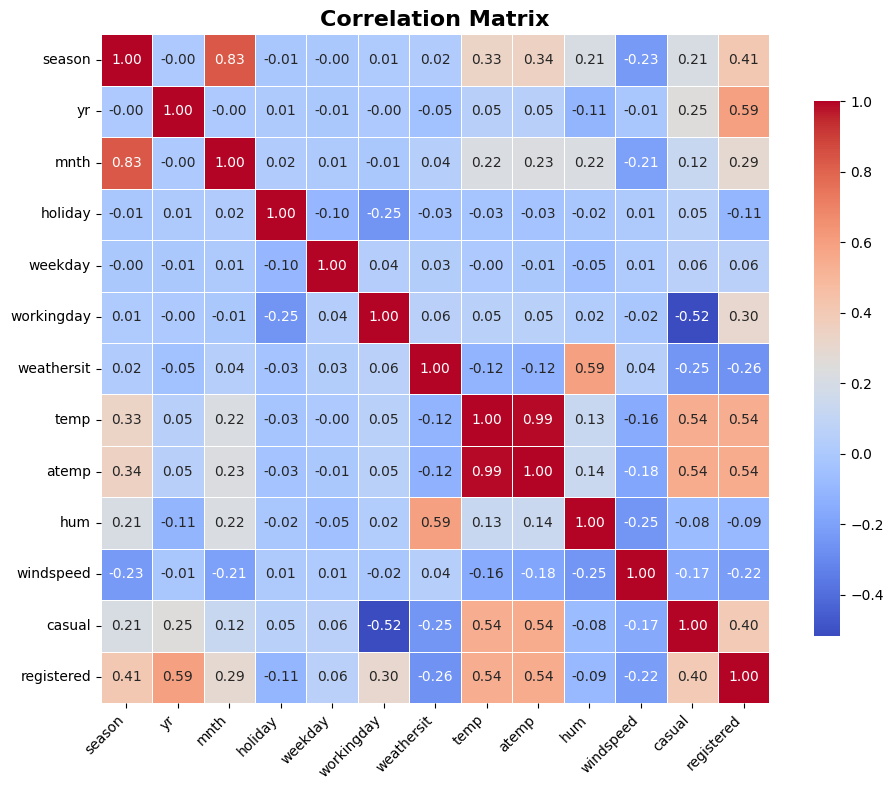

In [6]:
# Visualize Correlation
def viz_correlation(corr):
    """
    This function visualizes the correlation matrix using a heatmap.

    Parameters:
    corr (DataFrame or 2D array): The correlation matrix to be visualized.

    Returns:
    None: Displays a heatmap of the correlation matrix.
    """
    plt.figure(figsize=(10, 8)) 
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, square=True, cbar_kws={'shrink': 0.8})
    plt.title('Correlation Matrix', fontsize=16, fontweight='bold')  
    plt.xticks(rotation=45, ha='right', fontsize=10)  
    plt.yticks(fontsize=10)  
    plt.tight_layout() 
    plt.show()

viz_correlation(corr)

**Comment:**
  
temp and atemp are highly correlated features with a correlation of 0.99.  
They are also highly correlated with several other features:  
- casual (0.54), registered (0.54)  
- spring_Summer (0.68 & 0.66)  
- season_Winter (-0.62, -0.63)  

season and month are also highly correlated features with a correlation of 0.83.

The presence of several other highly correlated features suggests that we might need to remove some of them before training the model.  
However, for now, let's proceed with the analysis.

In [7]:
# Create Formula String to test a OLS Model
def create_formula_str(features, target = target):
    """
    This function generates a formula string for use in statistical modeling or machine learning 
    by concatenating the target variable and features.

    Parameters:
    features (list): A list of feature column names.
    target (str): The target variable (default is 'target').

    Returns:
    str: A formula string in the format 'target ~ feature1 + feature2 + ...'
    """
    formula_str = target + '~' + '+'.join(features[:])
    return formula_str

features = df.select_dtypes("number").drop(columns = [target]).columns
formula_str = create_formula_str(features, target)
formula_str

'cnt~season+yr+mnth+holiday+weekday+workingday+weathersit+temp+atemp+hum+windspeed+casual+registered'

In [8]:
# Fit an OLS Model
def fit_ols(formula, data):
    """
    This function fits an Ordinary Least Squares (OLS) regression model using the given formula and data.

    Parameters:
    formula (str): The formula string specifying the target and features (e.g., 'target ~ feature1 + feature2').
    data (DataFrame): The data containing the variables specified in the formula.

    Returns:
    fitted: The fitted OLS model, which includes model parameters and statistical details.
    """
    model = smf.ols(formula = formula, data = data)
    fitted = model.fit()

    return fitted
fitted = fit_ols(formula_str, df)
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.405e+31
Date:                Wed, 04 Dec 2024   Prob (F-statistic):               0.00
Time:                        13:36:58   Log-Likelihood:                 18596.
No. Observations:                 731   AIC:                        -3.716e+04
Df Residuals:                     717   BIC:                        -3.710e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6.963e-13   6.22e-13      1.119      0.2

**Comment:**
1. **Model Overview**: 
   - **R-squared and Adjusted R-squared** are 1.000, meaning the model explains all the variation in `cnt`, but this might indicate **overfitting**.
2. **Significance**:
   - Some features aren‚Äôt significant (p > 0.05), but `casual` and `registered` are highly significant with coefficients of 1.000, suggesting perfect correlation with `cnt`.
3. **Multicollinearity**:
   - **temp** and **atemp** are highly correlated (0.99), causing **multicollinearity** and instability in the model. The **condition number** is high, confirming this issue.
4. **Diagnostics**:
   - The Omnibus and Jarque-Bera tests suggest that the residuals (errors) are not normally distributed, which could violate assumptions of the model.
   - The Durbin-Watson statistic is very low (0.413), which means there could be autocorrelation (residuals influencing each other over time).
  
**Resolution:** I'll explore Ridge and Lasso Regression in the end. But for not, let's keep exploring

In [9]:
# An attempt to remove some of the features using variance inflation factor metric
def calculate_vif(df, features, target):
    """
    Calculate the Variance Inflation Factor (VIF) for each feature in the dataset.
    
    The VIF quantifies how much the variance of a regression coefficient is inflated due to 
    multicollinearity with other features. High VIF values (usually above 10) indicate 
    multicollinearity, suggesting that the feature may be redundant and could be removed.

    Parameters:
    df (DataFrame): The input DataFrame containing the features.
    features (list): A list of feature names to calculate the VIF for.

    Returns:
    DataFrame: A DataFrame with the features and their corresponding VIF values.
    """
    VIF = pd.DataFrame()
    df2 = df.drop(columns = [target])
    VIF['Features'] = df2.columns
    VIF['Variance'] = [variance_inflation_factor(df2.values, i) for i in range(len(df2.columns))]

    return VIF
VIF = calculate_vif(df, features, target)
VIF

Features    Variance
0       season   24.810434
1           yr    5.492945
2         mnth   15.362944
3      holiday    1.107253
4      weekday    3.262735
5   workingday    9.451166
6   weathersit   14.486723
7         temp  493.546386
8        atemp  571.935452
9          hum   28.093844
10   windspeed    5.360127
11      casual    8.566103
12  registered   38.692607

**Comment:**

The **Variance Inflation Factor (VIF)** helps identify **multicollinearity**, which is when features are highly correlated with each other. This can cause problems in regression models.
- **0 < VIF < 5**: Keep these features. They don't have much multicollinearity.
- **VIF ‚â• 5**: Keep these features but check them closely. They may be a bit correlated with other features.
- **VIF ‚â• 10**: Remove these features because they are highly correlated with others and can cause issues in the model.

**I will:**
- **Remove** features with a VIF of **10 or more** e.g `registered`, `hum`....
- **Check** features with a VIF between **5 and 10** to see if they should stay or be removed based on how they affect the model e.g `windspeed`, `atemp`

In [10]:
# Subset to variance inflation factors of less than 10 and retrain the OLS model
VIF = VIF[VIF['Variance'] < 10]

features = list(VIF['Features'].values)
formula_str = target + '~' +'+'.join(features[:])

fitted = fit_ols(formula_str, df)
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     503.4
Date:                Wed, 04 Dec 2024   Prob (F-statistic):          1.97e-254
Time:                        13:36:58   Log-Likelihood:                -5969.1
No. Observations:                 731   AIC:                         1.195e+04
Df Residuals:                     724   BIC:                         1.198e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    832.2216    141.670      5.874      0.0

**Comment:**
1. **Model Overview**: 
   - A reduced **R-squared and Adjusted R-squared** means that the model may not overfit, as it stands.
2. **Significance**:
   - Some features are still not significant (p > 0.05) i.e `holiday` and `weekday`
3. **Multicollinearity**:
   - The **condition number** is still high, meaning that the issue of multicollinearity still persist
4. **Diagnostics**:
   - The Omnibus and Jarque-Bera tests (both < 0.05) suggest that the residuals (errors) are normally distributed
   - The Durbin-Watson statistic is still low (0.413), which means there could be autocorrelation (residuals influencing each other over time).
  
**Next Steps:**
- **Remove Insignificant Features**: Use the **p-values** from the model summary to find features that significantly affect the target variable. These are features with a **p-value less than the threshold value** (commonly 0.05).
- **Retrain the Model**: After removing insignificant features, retrain the model with only the significant features to improve its performance and address some of the identified issues.

**Why?:**
- **Multicollinearity** can inflate the standard errors of coefficients, making it hard to determine the true effect of a feature on the target.
- **Autocorrelation** indicates that patterns in the residuals are not random, which violates regression assumptions and may suggest the need for a more advanced model.

In [11]:
def get_significant_features(model, significance_level = 0.05):
    p_values = model.pvalues
    significant_features = p_values[p_values < significance_level].index.tolist()
    significant_features = [feature for feature in significant_features if feature != 'Intercept']

    return significant_features

significant_features = get_significant_features(fitted, significance_level = 0.05)
significant_features

['yr', 'workingday', 'windspeed', 'casual']

In [12]:
# Retrain Model using the significant features
formula_str = target + '~' +'+'.join(significant_features[:])

model_significant = fit_ols(formula_str, df)
print(model_significant.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     756.8
Date:                Wed, 04 Dec 2024   Prob (F-statistic):          3.05e-257
Time:                        13:36:58   Log-Likelihood:                -5969.2
No. Observations:                 731   AIC:                         1.195e+04
Df Residuals:                     726   BIC:                         1.197e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    856.2042    133.651      6.406      0.0

**Comment:**
1. **Significance**:
   - The remaining features are (p < 0.05)
3. **Multicollinearity**:
   - The **condition number** is still high, meaning that the issue of multicollinearity still persist
4. **Diagnostics**:
   - The Omnibus and Jarque-Bera tests (both < 0.05) suggest that the residuals (errors) are normally distributed
   - The Durbin-Watson statistic is still low (0.858), which means there could be autocorrelation (residuals influencing each other over time).
   - A good Durbin-Watson statistic approximates to 2
  
**Next Steps: Check independence of features against the model residual**

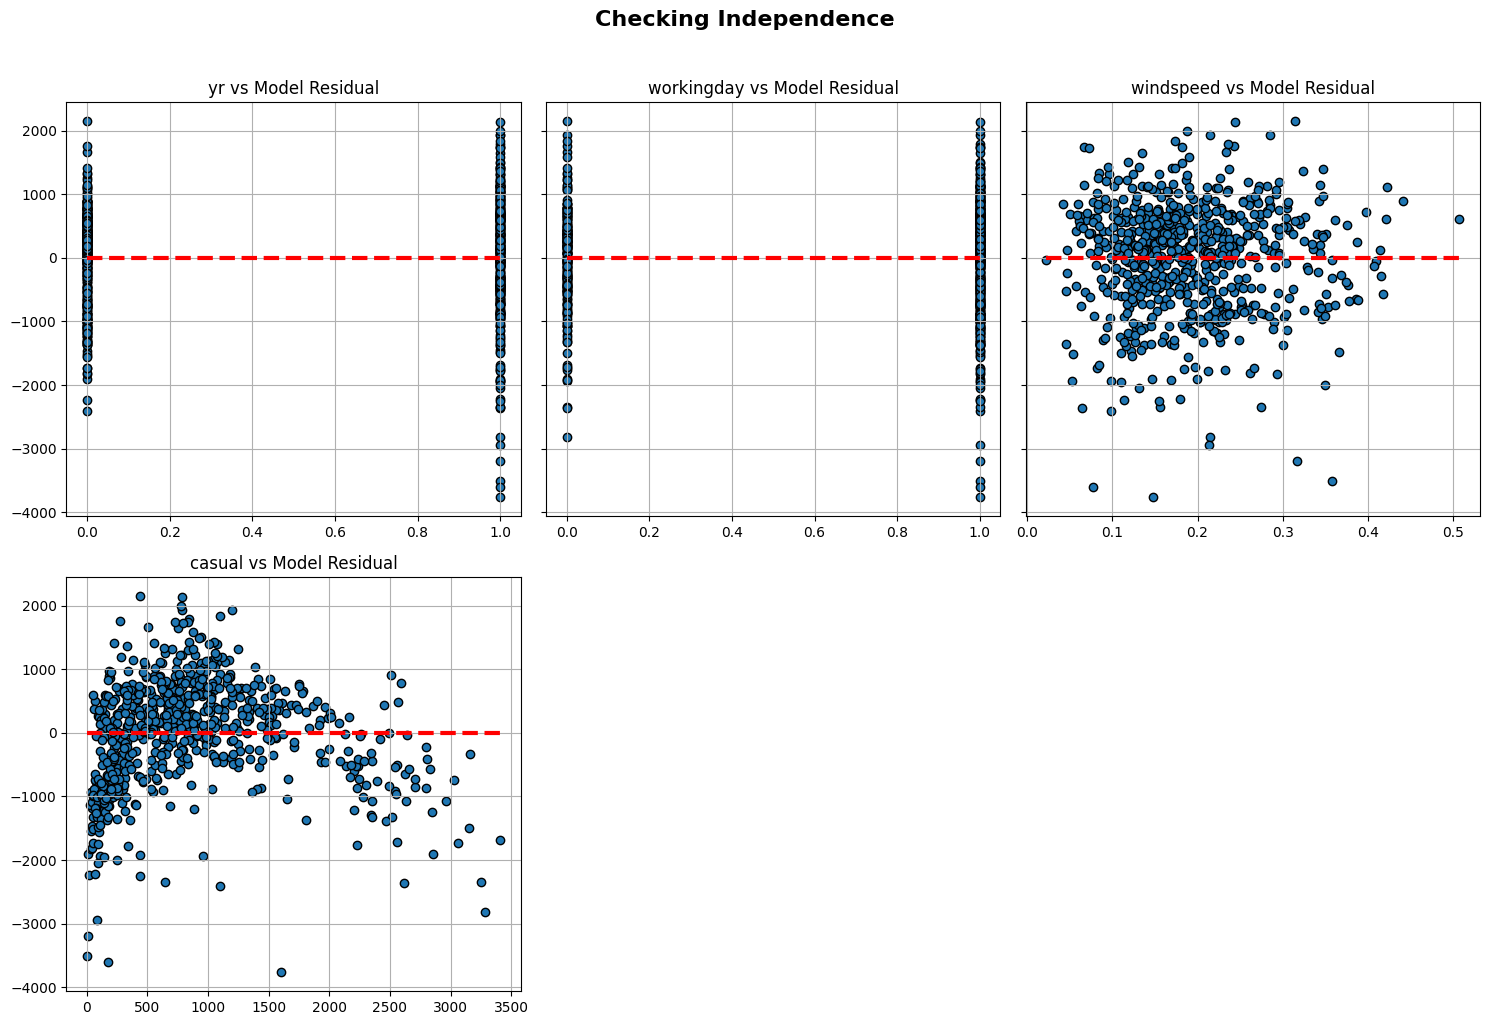

In [13]:
# Check Independence in the Dataset
def check_independence(df, target='cnt', features=features):
    """
    Visualizes the independence of residuals in a dataset by plotting each feature against the model's residuals.
    
    Parameters:
    df (DataFrame): The dataset containing the features and target variable.
    target (str): The name of the target variable in the dataset. Default is 'cnt'.
    features (list): A list of feature names to check against the residuals.
    
    Returns:
    tuple: A tuple containing the figure and axes of the resulting plots.

    This function creates scatter plots for each feature in `features` against the residuals from the 
    significant model (`model_significant.resid`). It also includes a horizontal line at y=0 to visually 
    assess if the residuals are randomly distributed around zero, which indicates independence.

    Notes:
    - The function assumes the model's residuals (`model_significant.resid`) are available.
    - Features without data in the scatter plots are automatically removed.
    - A red dashed line (y=0) is added to aid visual inspection.
    """
    fig, ax = plt.subplots(2, 3, figsize=(15, 10), sharey=True)
    ax = ax.flatten()  # ax.ravel()
    fig.suptitle("Checking Independence", fontsize=16, fontweight='bold', y=1.02)
    
    for i, column in enumerate(features):
        ax[i].scatter(df[column], model_significant.resid, edgecolor='k')
        ax[i].set_title(f'{column} vs Model Residual', fontsize=12)
        
        ax[i].hlines(y=0, xmin=df[column].min(), xmax=df[column].max(), linestyle='--', color='red', lw=3)
        ax[i].grid()
    [fig.delaxes(axes) for axes in ax if not axes.has_data()]
    plt.tight_layout()
    return fig, ax

fig, ax = check_independence(df, target='cnt', features=significant_features)

**Comment:**

The features plotted against the model residuals are not independent. `yr` and `workingday` are categorical, and their residuals are clustered around specific categorical values instead of being randomly spread. 
For the `casual` feature, the residuals are more spread out, but they are not close to zero. Additionally, there are clusters of points, which suggests a lack of independence.

This shows that the residuals are not independent, violating the assumption of independence in regression analysis.

**Next Step: Check for Heteroskedascity**

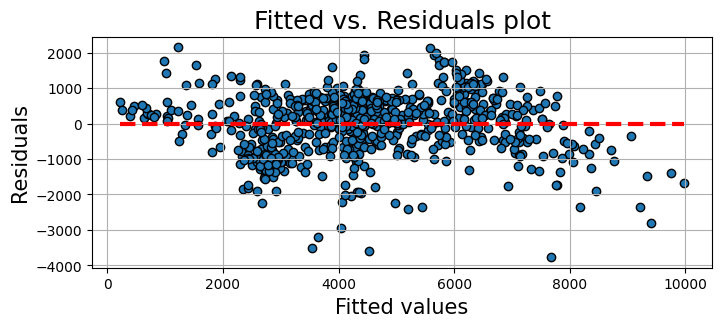

In [14]:
# Check heteroskedascity of model residuals
def model_heteroskedascity(model):
    """
    Creates a scatter plot to check for heteroskedasticity in the residuals of a regression model.

    Parameters:
    model (statsmodels.regression.linear_model.RegressionResultsWrapper): 
        The fitted regression model whose residuals are to be analyzed.

    Returns:
    None: Displays a scatter plot of fitted values against residuals.

    This function plots the fitted values of the model on the x-axis and the residuals on the y-axis.
    A horizontal red dashed line at y=0 is included to help visually assess if the residuals are spread 
    randomly (homoskedasticity) or show a pattern (heteroskedasticity).

    Notes:
    - Homoskedasticity means the residuals are evenly distributed around y=0, indicating no systematic 
      variance in errors.
    - Heteroskedasticity means the residuals exhibit a pattern or non-uniform spread, which violates a key 
      assumption of linear regression.
    """
    plt.figure(figsize=(8, 3))
    plt.scatter(x=model.fittedvalues, y=model.resid, edgecolor='k')
    xmin = min(model.fittedvalues)
    xmax = max(model.fittedvalues)
    plt.hlines(y=0, xmin=xmin, xmax=xmax, color='red', linestyle='--', lw=3)
    plt.xlabel("Fitted values", fontsize=15)
    plt.ylabel("Residuals", fontsize=15)
    plt.title("Fitted vs. Residuals plot", fontsize=18)
    plt.grid(True)
    plt.show()

model_heteroskedascity(model_significant)

**Comment:**
- There are clusters of points around fitted values close to 3000, at 4000, and just after 6000.  
- Negative residuals are more frequent than positive residuals.  

This indicates heteroskedasticity in the residuals of the regression model.  

To confirm the presence or absence of heteroskedasticity, we will use the Breusch-Pagan test.  

In [15]:
def test_of_heteroskedasticity(model):
    """
    Performs the Breusch-Pagan test for heteroskedasticity on a regression model.

    Parameters:
    model (statsmodels.regression.linear_model.RegressionResultsWrapper): 
        The fitted regression model to test for heteroskedasticity.

    Returns:
    tuple: A tuple containing:
        - lm_pvalue (float): The p-value for the Lagrange Multiplier (LM) test.
        - F_pvalue (float): The p-value for the F-test.

    Notes:
    - A low p-value (typically < 0.05) for either test indicates the presence of heteroskedasticity.
    - The Breusch-Pagan test examines whether the residual variance depends on the explanatory variables.
    """
    lm_statistic, lm_pvalue, F_statistic, F_pvalue = sms.het_breuschpagan(model.resid, model.model.exog)
    return lm_pvalue, F_pvalue
lm_pvalue, F_pvalue = test_of_heteroskedasticity(model_significant)
print(f'lm_pvalue : {lm_pvalue:.4f}\nf_pvalue : {F_pvalue:.4f}')

lm_pvalue : 0.0020
f_pvalue : 0.0019


**Comment (Breusch-Pagan Test Results):**
- **LM p-value:** 0.0020
- **F p-value:** 0.0019 

The p-values are below the significance threshold of 0.05, indicating the presence of heteroskedasticity in the model residuals.
- **Null Hypothesis:** There is no heteroskedasticity in the model residuals
- **Alternate Hypothesis:** There is heteroskedasticity in the model residuals

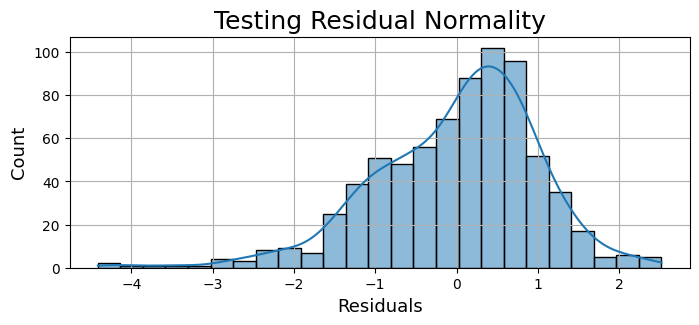

In [16]:
def plot_residual_normality(model, title="Testing Residual Normality"):
    """
    Plot a histogram to test the normality of residuals.

    Parameters:
    model : statsmodels regression model
        The fitted regression model whose residuals are to be analyzed.
    title : str, optional
        The title of the plot (default is "Testing Residual Normality").

    Returns:
    None
        Displays a histogram of the residuals with a Kernel Density Estimate (KDE) curve.
    """
    plt.figure(figsize=(8, 3))
    sns.histplot(model.resid_pearson, kde = True)
    plt.xlabel("Residuals", fontsize=13)
    plt.ylabel("Count", fontsize=13)
    plt.title(title, fontsize=18)
    plt.grid(True)
    plt.show()

plot_residual_normality(model_significant)

**Comment:**

The histogram shows that the residuals have a peak at 0, which suggests they are centered around 0. However, the distribution is skewed to the left, meaning there are more negative residuals than positive ones.
1. **Peak at 0**: The residuals are centered around 0, which is a good sign for normality.
2. **Left Skew**: The left skew indicates that the residuals are not symmetrically distributed and there are more negative values.

Although the residuals are close to normal, the skewness suggests that the residuals are not perfectly normal, which could affect the model's performance.

<Figure size 800x600 with 0 Axes>

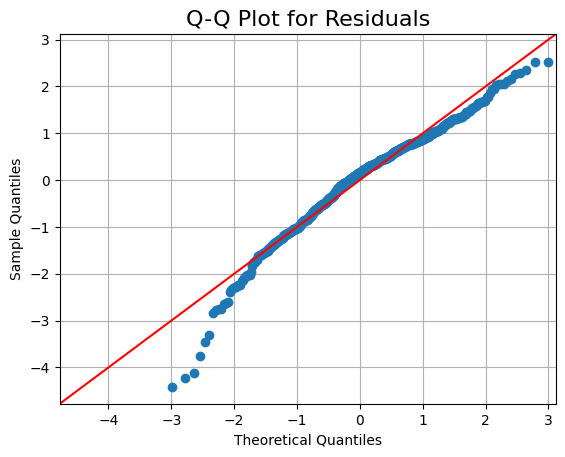

In [17]:
def plot_qq_from_model(model, line='45', title="Q-Q Plot for Residuals"):
    """
    Generates a Q-Q plot to check if the residuals from a model follow a normal distribution.

    Parameters:
    - model: The fitted model object from statsmodels.
    - line: Type of reference line to use on the plot ('45', 's', or 'r'). Default is '45'.
    - title: The title of the Q-Q plot. Default is 'Q-Q Plot for Residuals'.

    Note:
    - If the points lie along the reference line (typically the 45-degree line), the residuals are approximately normally distributed.
    - If the points deviate from the line, especially at the ends, it indicates the residuals are not normal, showing skewness or heavy tails.
    """
    # Calculate the Pearson residuals from the model
    residuals = model.resid_pearson
    
    # Plot the Q-Q plot
    plt.figure(figsize=(8, 6))
    qqplot(residuals, line=line, fit=True)
    plt.title(title, fontsize=16)
    plt.grid(True)
    plt.show();


plot_qq_from_model(model_significant);

**Comments:**
There are deviations at both ends of the line:
- **Left side**: Points above the line suggest more extreme negative values than expected, indicating a left skew.
- **Right side**: Points below the line suggest fewer extreme positive values than expected, showing a right skew.

This means the residuals are not perfectly normal, which could affect the model's accuracy.

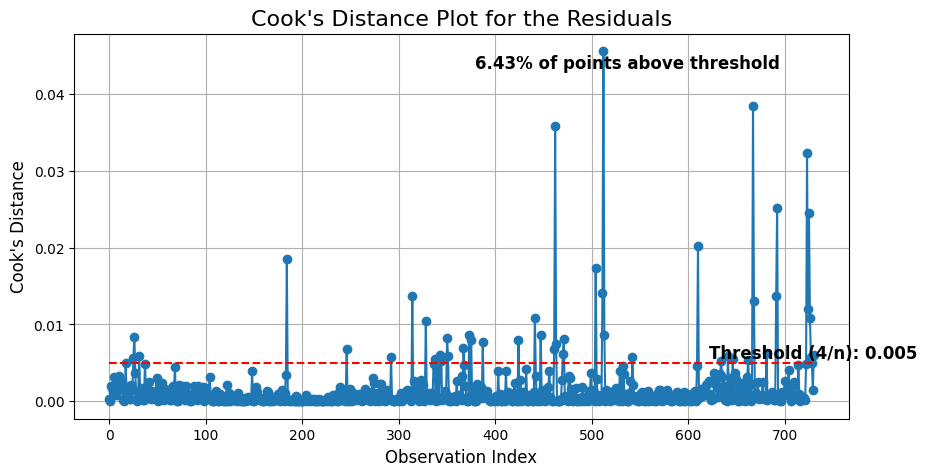

In [18]:
def plot_cooks_distance(model, title="Cook's Distance Plot for the Residuals"):
    """
    Generates a Cook's distance plot for a given model's residuals to identify influential points.
    
    Parameters:
    - model: The fitted statsmodels OLS model object.
    - title: Title of the Cook's distance plot. Default is "Cook's Distance Plot for the Residuals".
    
    Interpretation:
    - High Cook's distance**: Data points with large values (usually greater than 1 or 4/n) are influential. These points may have a significant impact on the model and should be investigated further.
    - Low Cook's distance**: Points with small values have little impact on the model and are considered less influential.
    """

    # Calculate Cook's distance from the model
    inf = OLSInfluence(model)
    c, p = inf.cooks_distance
    
    # Plot Cook's distance
    plt.figure(figsize=(10, 5))
    plt.plot(np.arange(len(c)), c, marker='o', linestyle='-')
    
    threshold = round(4/len(c), 3)
    plt.hlines(y = threshold, xmin = 0, xmax = len(c) - 1, color = 'red', linestyle = '--')
    plt.text(x = len(c) * 0.85, y=threshold, s=f'Threshold (4/n): {threshold}', color='black', fontsize=12, verticalalignment='bottom', fontweight='bold')

    
    # Calculate the number of points above the threshold
    points_above_threshold = np.sum(c > threshold)
    percentage_above_threshold = (points_above_threshold / len(c)) * 100
    plt.text(x=len(c) * 0.95, y=max(c)*0.95, s=f'{round(percentage_above_threshold, 2)}% of points above threshold', color='black', fontsize=12, fontweight='bold', horizontalalignment='right')

    plt.title(title, fontsize=16)
    plt.xlabel("Observation Index", fontsize=12)
    plt.ylabel("Cook's Distance", fontsize=12)
    plt.grid(True)
    plt.show()
plot_cooks_distance(model_significant)

**Comment:**
- None of the points are above 1.
- 6.43% of the points are above the 4/n threshold, indicating they are influential points, though not highly influential.

Let's remove these points to see if the model improves.

In [19]:
# Get Cook's distance
influence = model_significant.get_influence()
cooks_distance = influence.cooks_distance[0]

# Get influential points
threshold = 0.005
influential_points = df.index[cooks_distance > threshold]
df_influential_points_dropped = df.drop(influential_points)

# Retrain the model
model_influential_points_dropped = fit_ols(formula_str, df_influential_points_dropped)
print(model_influential_points_dropped.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     1118.
Date:                Wed, 04 Dec 2024   Prob (F-statistic):          4.98e-297
Time:                        13:37:03   Log-Likelihood:                -5436.7
No. Observations:                 684   AIC:                         1.088e+04
Df Residuals:                     679   BIC:                         1.091e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    715.7259    116.029      6.168      0.0

**Comments:** The issues still persist. We'll select the features using another method

## Variable Selection and Feature Selection (2): Using Correlation and p-values

In this section, the goal is to use correlation-based methods to select the most relevant variables (features) for building a predictive model. Correlation analysis helps identify relationships between variables, which allows us to focus on those that have a strong association with the target variable and remove redundant or irrelevant features.

### Key Concepts:
- **Correlation Coefficient**: Measures the strength and direction of the relationship between two variables. Values range from -1 to 1, where:
  - **1** indicates a perfect positive correlation,
  - **-1** indicates a perfect negative correlation,
  - **0** indicates no correlation.
- **Correlation Matrix**: A matrix that shows the correlation coefficients between all pairs of variables in the dataset. High correlation (either positive or negative) between two independent variables indicates potential multicollinearity.

In [20]:
df2 = df.copy()
df2.head()

season  yr  mnth  holiday  weekday  workingday  weathersit      temp  \
0       1   0     1        0        6           0           2  0.344167   
1       1   0     1        0        0           0           2  0.363478   
2       1   0     1        0        1           1           1  0.196364   
3       1   0     1        0        2           1           1  0.200000   
4       1   0     1        0        3           1           1  0.226957   

      atemp       hum  windspeed  casual  registered   cnt  
0  0.363625  0.805833   0.160446     331         654   985  
1  0.353739  0.696087   0.248539     131         670   801  
2  0.189405  0.437273   0.248309     120        1229  1349  
3  0.212122  0.590435   0.160296     108        1454  1562  
4  0.229270  0.436957   0.186900      82        1518  1600

In [21]:
feature_correlation = df2.corr()[target].sort_values(ascending = False)
feature_correlation

cnt           1.000000
registered    0.945517
casual        0.672804
atemp         0.631066
temp          0.627494
yr            0.566710
season        0.406100
mnth          0.279977
weekday       0.067443
workingday    0.061156
holiday      -0.068348
hum          -0.100659
windspeed    -0.234545
weathersit   -0.297391
Name: cnt, dtype: float64

In [22]:
# Get the p-values and the correlation coefficient of the features
dict_pvalues = {}
features = [col for col in df2.columns if col != target]
for feature in features:
    p = round(pearsonr(df2[feature], df2[target])[1], 5)

    dict_pvalues[feature] = {'correlation_coefficient' : feature_correlation[feature], 
                            'p_value' : p
                            }


df_pvalue  = pd.DataFrame(dict_pvalues).T.sort_values(by = 'p_value', ascending = False)
df_pvalue

correlation_coefficient  p_value
workingday                 0.061156  0.09849
weekday                    0.067443  0.06839
holiday                   -0.068348  0.06476
hum                       -0.100659  0.00645
season                     0.406100  0.00000
yr                         0.566710  0.00000
mnth                       0.279977  0.00000
weathersit                -0.297391  0.00000
temp                       0.627494  0.00000
atemp                      0.631066  0.00000
windspeed                 -0.234545  0.00000
casual                     0.672804  0.00000
registered                 0.945517  0.00000

In [23]:
#Set threshold of p to 0.05; for instance
df_pvalue = df_pvalue.query('p_value < 0.06')
df_pvalue

correlation_coefficient  p_value
hum                       -0.100659  0.00645
season                     0.406100  0.00000
yr                         0.566710  0.00000
mnth                       0.279977  0.00000
weathersit                -0.297391  0.00000
temp                       0.627494  0.00000
atemp                      0.631066  0.00000
windspeed                 -0.234545  0.00000
casual                     0.672804  0.00000
registered                 0.945517  0.00000

In [24]:
# Get the Features within the threshold and recalculate the correlation
X_corr_names = list(df_pvalue.index)
corr = df2[X_corr_names].corr()

corr

hum    season        yr      mnth  weathersit      temp  \
hum         1.000000  0.205445 -0.110651  0.222204    0.591045  0.126963   
season      0.205445  1.000000 -0.001844  0.831440    0.019211  0.334315   
yr         -0.110651 -0.001844  1.000000 -0.001792   -0.048727  0.047604   
mnth        0.222204  0.831440 -0.001792  1.000000    0.043528  0.220205   
weathersit  0.591045  0.019211 -0.048727  0.043528    1.000000 -0.120602   
temp        0.126963  0.334315  0.047604  0.220205   -0.120602  1.000000   
atemp       0.139988  0.342876  0.046106  0.227459   -0.121583  0.991702   
windspeed  -0.248489 -0.229046 -0.011817 -0.207502    0.039511 -0.157944   
casual     -0.077008  0.210399  0.248546  0.123006   -0.247353  0.543285   
registered -0.091089  0.411623  0.594248  0.293488   -0.260388  0.540012   

               atemp  windspeed    casual  registered  
hum         0.139988  -0.248489 -0.077008   -0.091089  
season      0.342876  -0.229046  0.210399    0.411623  
yr          0.046106  -0.011817  0.248546    0.594248  
mnth        0.227459  -0.207502  0.123006    0.293488  
weathersit -0.121583   0.039511 -0.247353   -0.260388  
temp        0.991702  -0.157944  0.543285    0.540012  
atemp       1.000000  -0.183643  0.543864    0.544192  
windspeed  -0.183643   1.000000 -0.167613   -0.217449  
casual      0.543864  -0.167613  1.000000    0.395282  
registered  0.544192  -0.217449  0.395282    1.000000

In [25]:
# Filter out high correlations (say 0.6)
r, c = np.where(np.abs(corr) > 0.6)

off_diagonal = np.where(r != c)
corr.iloc[r[off_diagonal], c[off_diagonal]].drop_duplicates().T.drop_duplicates().T

mnth    season     atemp      temp
season  0.831440  1.000000  0.342876  0.334315
mnth    1.000000  0.831440  0.227459  0.220205
temp    0.220205  0.334315  0.991702  1.000000
atemp   0.227459  0.342876  1.000000  0.991702

**Comment:** Drop all features here and use the remaining to train the model

In [26]:
to_remove = ['temp', 'season', 'atemp', 'mnth']
X_corr_names = list(filter(lambda x: x not in to_remove, X_corr_names))
X_corr_names

['hum', 'yr', 'weathersit', 'windspeed', 'casual', 'registered']

## Variable Selection and Feature Selection (3) - Using Variance Thresholds

In this section, we will explore **Variance Thresholds** as a method for feature selection. The idea behind this method is to remove features that do not vary much across the dataset, as these features are unlikely to provide valuable information for predictive modeling.

### Key Concept: Variance Threshold
- **Variance** measures the spread or dispersion of a set of values. Features with low variance (close to constant) contain very little information and are usually not useful for making predictions.
- **Variance Thresholding** is a feature selection technique where we remove features with variance below a certain threshold. This is based on the assumption that features with little or no variation are less likely to be informative.

In [27]:
df2.head()

season  yr  mnth  holiday  weekday  workingday  weathersit      temp  \
0       1   0     1        0        6           0           2  0.344167   
1       1   0     1        0        0           0           2  0.363478   
2       1   0     1        0        1           1           1  0.196364   
3       1   0     1        0        2           1           1  0.200000   
4       1   0     1        0        3           1           1  0.226957   

      atemp       hum  windspeed  casual  registered   cnt  
0  0.363625  0.805833   0.160446     331         654   985  
1  0.353739  0.696087   0.248539     131         670   801  
2  0.189405  0.437273   0.248309     120        1229  1349  
3  0.212122  0.590435   0.160296     108        1454  1562  
4  0.229270  0.436957   0.186900      82        1518  1600

In [28]:
X_data = df2.drop(columns = [target])
y_data = df2[target]

In [29]:
#Scale the dataframe to ensure that all features are on the same scale. MinMaxScaler and StandardScaler are possible options
scalar = MinMaxScaler()
X_scaled = scalar.fit_transform(X_data)
X_normalized = pd.DataFrame(X_scaled, columns = X_data.columns)
X_normalized.head()

season   yr  mnth  holiday   weekday  workingday  weathersit      temp  \
0     0.0  0.0   0.0      0.0  1.000000         0.0         0.5  0.355170   
1     0.0  0.0   0.0      0.0  0.000000         0.0         0.5  0.379232   
2     0.0  0.0   0.0      0.0  0.166667         1.0         0.0  0.171000   
3     0.0  0.0   0.0      0.0  0.333333         1.0         0.0  0.175530   
4     0.0  0.0   0.0      0.0  0.500000         1.0         0.0  0.209120   

      atemp       hum  windspeed    casual  registered  
0  0.373517  0.828620   0.284606  0.096538    0.091539  
1  0.360541  0.715771   0.466215  0.037852    0.093849  
2  0.144830  0.449638   0.465740  0.034624    0.174560  
3  0.174649  0.607131   0.284297  0.031103    0.207046  
4  0.197158  0.449313   0.339143  0.023474    0.216286

In [30]:
#Calculate the variance based on a threshold; threshold can be adjusted
threshold = 0.05
selector = VarianceThreshold(threshold = threshold)
selector.fit_transform(X_normalized)
var = selector.variances_
var

array([0.13691161, 0.24999953, 0.09834216, 0.02790249, 0.1114909 ,
       0.21614601, 0.07412592, 0.05195412, 0.04569427, 0.02142021,
       0.02549024, 0.04053614, 0.05067951])

In [31]:
# Convert variance to dataframe
var_dict = [
        {'Feature' : feat, 'Variance' : var}
    for feat, var in zip(X_normalized.columns, var)
    
]
variance_df = pd.DataFrame(var_dict).sort_values(by = 'Variance', ascending = False)
variance_df

Feature  Variance
1           yr  0.250000
5   workingday  0.216146
0       season  0.136912
4      weekday  0.111491
2         mnth  0.098342
6   weathersit  0.074126
7         temp  0.051954
12  registered  0.050680
8        atemp  0.045694
11      casual  0.040536
3      holiday  0.027902
10   windspeed  0.025490
9          hum  0.021420

In [32]:
# Extract selected features based on the theshold
selected_features = variance_df.query(f'Variance > {threshold}')['Feature'].values
X_new = X_normalized[selected_features]
X_var_names = X_new.columns
X_var_names

Index(['yr', 'workingday', 'season', 'weekday', 'mnth', 'weathersit', 'temp',
       'registered'],
      dtype='object')

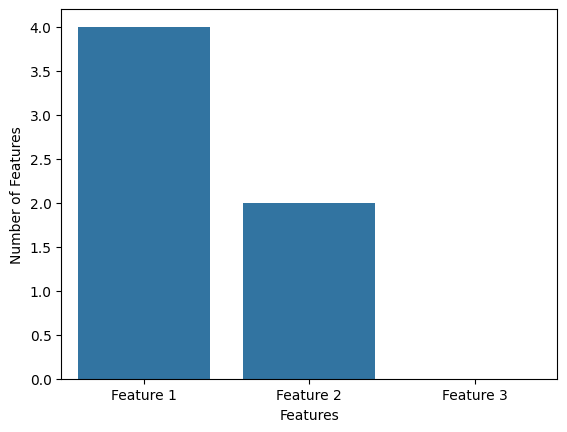

In [33]:
# Test other threshold values
features_1 = len(variance_df.query('Variance > 0.1')['Feature'].values)
features_2 = len(variance_df.query('Variance > 0.2')['Feature'].values)
features_3 = len(variance_df.query('Variance > 0.3')['Feature'].values)

sns.barplot(x = ['Feature 1', 'Feature 2', 'Feature 3'], 
            y = [features_1, features_2, features_3])
plt.xlabel("Features")
plt.ylabel("Number of Features");


**Comment:** An increment in the threshold value will decrease the number of features

## Model Building: Linear Regression

In this section, we will build a linear regression model to predict the target variable using the selected features. Linear regression is one of the simplest and most widely used regression techniques, making it an excellent starting point for predictive modeling.

### Key Concepts:
- **Linear Regression**: A regression technique that models the relationship between the target variable and one or more independent variables by fitting a linear equation to the observed data.
- **Equation**: The linear regression model is represented as:
  - `y = Œ≤‚ÇÄ + Œ≤‚ÇÅx‚ÇÅ + Œ≤‚ÇÇx‚ÇÇ + ... + Œ≤‚Çôx‚Çô + Œµ`
  - where `y` is the target variable, `x` are the features, `Œ≤` are the coefficients, and `Œµ` is the error term.
- **Assumptions**: Linear regression assumes:
  - Linear relationship between features and target.
  - Homoscedasticity (constant variance of residuals).
  - Independence of errors.
  - Normally distributed residuals.
  - No multicollinearity among features.

In [34]:
# Train-test split the original dataset
X_train, X_test, y_train, y_test = train_test_split(X_data,
                                                    y_data,
                                                    test_size=0.20,
                                                    shuffle=False)

In [35]:
# Get training and testing data for variance threshold model
X_var_train = X_train[X_var_names]
X_var_test = X_test[X_var_names]

# Get training and testing data for correlation threshold model
X_corr_train = X_train[X_corr_names]
X_corr_test = X_test[X_corr_names]

# Instantiate and train Models
lm = LinearRegression()
lm_corr = LinearRegression()
lm_var = LinearRegression()

lm.fit(X_train, y_train);
lm_corr.fit(X_corr_train,y_train);
lm_var.fit(X_var_train,y_train);

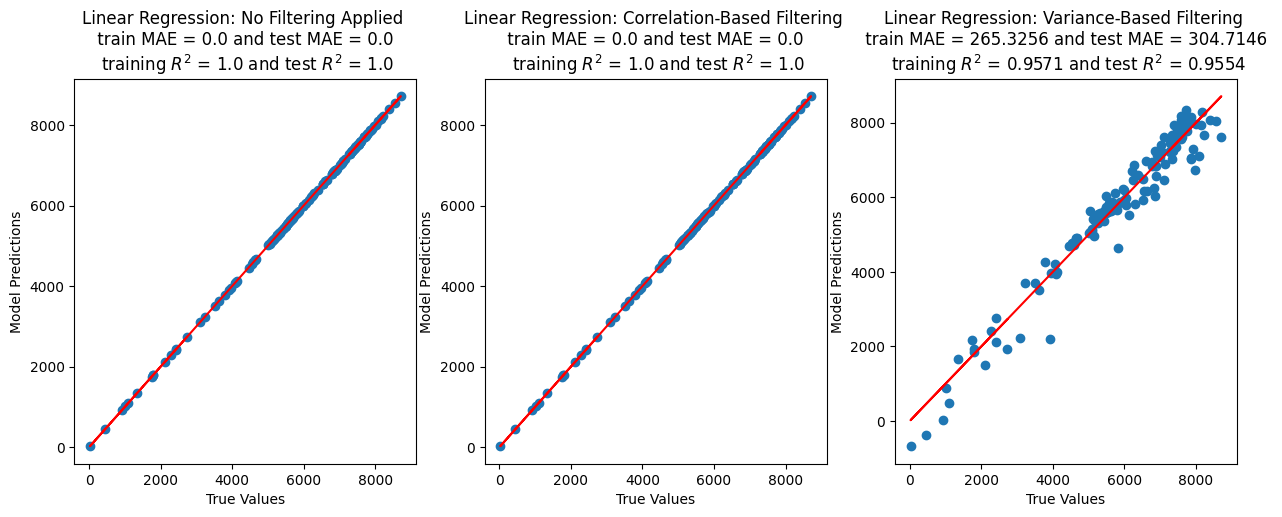

In [36]:
# Visualize the three models
f, ax = plt.subplots(figsize=(15, 5), nrows=1, ncols=3)

# Create list of titles and predictions to use in for loop
train_pred = [lm.predict(X_train), lm_corr.predict(X_corr_train), lm_var.predict(X_var_train)]
test_pred = [lm.predict(X_test), lm_corr.predict(X_corr_test), lm_var.predict(X_var_test)]

title = ['No Filtering Applied', 'Correlation-Based Filtering', 'Variance-Based Filtering']

# Loop through all axes to plot each model's results
for i in range(3):
    test_mae = round(mean_absolute_error(test_pred[i], y_test), 4)
    test_r2 = round(r2_score(test_pred[i], y_test), 4)
    train_mae = round(mean_absolute_error(train_pred[i], y_train), 4)
    train_r2 = round(r2_score(train_pred[i], y_train), 4)
    
    title_str = f"Linear Regression: {title[i]} \n train MAE = {train_mae} and " + \
                f"test MAE = {test_mae} \n training $R^{2}$ = {train_r2} and " + \
                f"test $R^{2}$ = {test_r2}"
    ax[i].set_title(title_str)
    ax[i].set_xlabel('True Values')
    ax[i].set_ylabel('Model Predictions')
    ax[i].plot(y_test, y_test, 'r')
    ax[i].scatter(y_test, test_pred[i])

**Comment:**
1. **Models with no threshold and correlation threshold:**
   - Both models had perfect results on the training and test data.
   - **Mean Absolute Error (MAE):** 0 for both train and test data.
   - **R-squared (R¬≤):** 1 (perfect fit) for both train and test data.
   - These perfect scores suggest the models memorized the data instead of learning patterns, meaning they are overfitting and may not work well on new data.
2. **Model with variance threshold:**
   - **Train Mean Absolute Error (MAE):** 257.95  
   - **Test Mean Absolute Error (MAE):** 290.20  
   - **Train R-squared (R¬≤):** 0.9597  
   - **Test R-squared (R¬≤):** 0.9551  
   - This model avoids overfitting, but its performance is not good enough. An MAE above 200 means the predictions are far from the actual values.
3. **Conclusion:**
    - The first two models are not reliable because they overfit.
    - The variance threshold model is slightly better, but the high MAE shows it still needs improvement.
    - This project shows how selecting the right variables can significantly impact a model's performance, either improving its accuracy or reducing its reliability.
  

Up Next, Let's try Ridge and Lasso Regressionüòâ

## Ridge Regression

In [37]:
df = wrangle('day.csv')

In [38]:
df['cnt'].describe()

count     731.000000
mean     4504.348837
std      1937.211452
min        22.000000
25%      3152.000000
50%      4548.000000
75%      5956.000000
max      8714.000000
Name: cnt, dtype: float64

In [39]:
X = df.drop(columns = ['cnt'])
y = df['cnt']

x_scaler = StandardScaler()

X_scaled = x_scaler.fit_transform(X)
X_normalized = pd.DataFrame(X_scaled, columns = X.columns)

In [40]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

# Ridge regression model with cross-validation
parameters = {'alpha': [1e-4, 1e-3, 1e-2, 1, 5, 10, 20, 100]}
ridge_model = GridSearchCV(Ridge(), parameters, scoring='r2', cv=5)

ridge_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 1, 5, 10, 20, 100]},
             scoring='r2')

## Lasso Regression

In [41]:
lasso_model = LassoCV(cv=5, random_state=42)
lasso_model.fit(X_train, y_train)

LassoCV(cv=5, random_state=42)

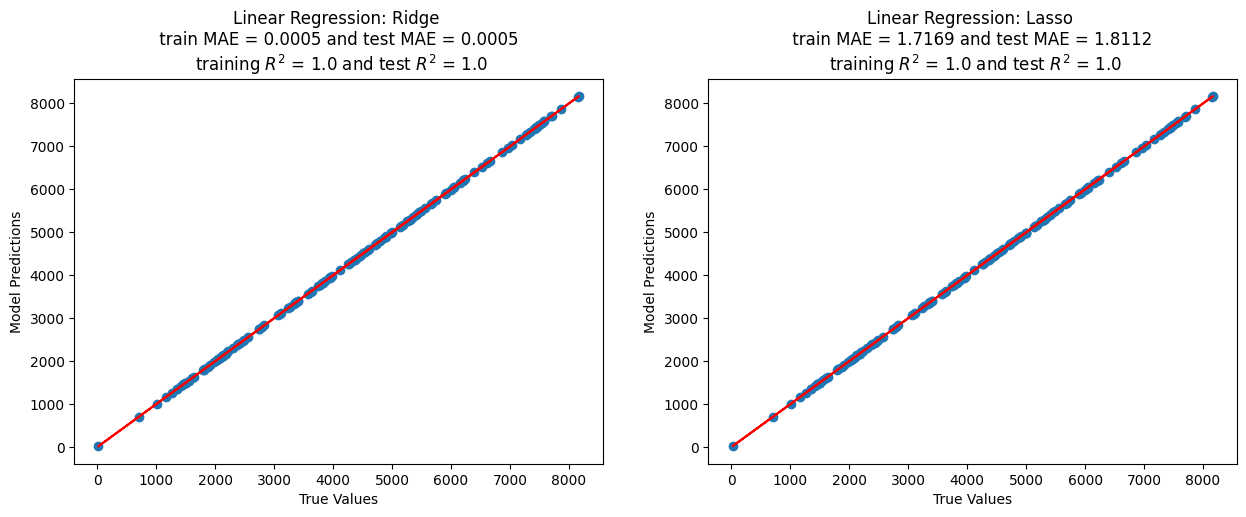

In [42]:
# Visualize the three models
f, ax = plt.subplots(figsize=(15, 5), nrows=1, ncols=2)

# Create list of titles and predictions to use in for loop
train_pred = [ridge_model.predict(X_train), lasso_model.predict(X_train)]
test_pred = [ridge_model.predict(X_test), lasso_model.predict(X_test)]

title = ['Ridge', 'Lasso']

# Loop through all axes to plot each model's results
for i in range(2):
    test_mae = round(mean_absolute_error(test_pred[i], y_test), 4)
    test_r2 = round(r2_score(test_pred[i], y_test), 4)
    train_mae = round(mean_absolute_error(train_pred[i], y_train), 4)
    train_r2 = round(r2_score(train_pred[i], y_train), 4)
    
    title_str = f"Linear Regression: {title[i]} \n train MAE = {train_mae} and " + \
                f"test MAE = {test_mae} \n training $R^{2}$ = {train_r2} and " + \
                f"test $R^{2}$ = {test_r2}"
    ax[i].set_title(title_str)
    ax[i].set_xlabel('True Values')
    ax[i].set_ylabel('Model Predictions')
    ax[i].plot(y_test, y_test, 'r')
    ax[i].scatter(y_test, test_pred[i])

**Comment:** Both models appear to Overfit

**Next Steps:** Let's try Non-Linear Models

### Decision Tree

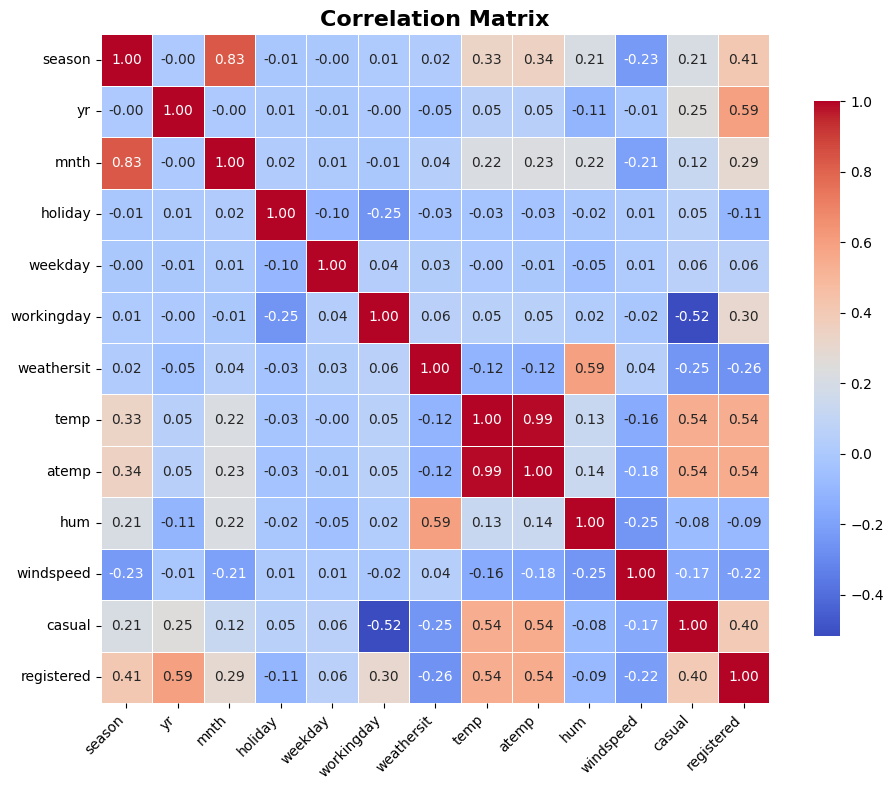

In [43]:
# Remove Highly Correlated Features
df = wrangle('day.csv')
target = 'cnt'

corr = correlation(df, target)
viz_correlation(corr)

In [44]:
#Drop Correlated Features and Transform the predictors
drop_col = ['temp', 'atemp', 'season']
df.drop(columns = drop_col, inplace = True)

X = df.drop(columns = ['cnt'])
y = df['cnt']

x_scaler = StandardScaler()

X_scaled = x_scaler.fit_transform(X)
X_normalized = pd.DataFrame(X_scaled, columns = X.columns)

#Split data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
#Fit Model
dec_tree = DecisionTreeRegressor(random_state = 42, max_depth = 3)
dec_tree.fit(X_train, y_train)

# Calculating MAE and R¬≤ for Decision Tree
dt_train_mae = mean_absolute_error(y_train, dec_tree.predict(X_train))
dt_train_r2 = r2_score(y_train, dec_tree.predict(X_train))

dt_test_mae = mean_absolute_error(y_test, dec_tree.predict(X_test))
dt_test_r2 = r2_score(y_test, dec_tree.predict(X_test))

print(f'Decision Tree\nTrain MAE: {dt_train_mae:.2f}\nTrain R2: {dt_train_r2:.2f}')
print(f'\nTest MAE: {dt_test_mae:.2f}\nTest R2: {dt_test_r2:.2f}')

Decision Tree
Train MAE: 434.98
Train R2: 0.92

Test MAE: 432.09
Test R2: 0.93


**Comment:** The drop in MAE shows that the model did well on new data, even though the improvement is small. 
The increase in R2 score also supports this. However, the MAE is still too high and not good enough.

**Next Step:** Use GridSearchCV to improve the model

In [46]:
param_grid = {'max_depth': range(1, 11)}
dt_grid_search = GridSearchCV(estimator=DecisionTreeRegressor(random_state=42), param_grid=param_grid, cv=5)
dt_grid_search.fit(X_train, y_train)

# Best Decision Tree model and its max_depth
dt_best_model = dt_grid_search.best_estimator_
dt_best_depth = dt_grid_search.best_params_['max_depth']

# Calculating MAE and R¬≤ for the best Decision Tree model
dt_train_mae = mean_absolute_error(y_train, dt_best_model.predict(X_train))
dt_train_r2 = r2_score(y_train, dt_best_model.predict(X_train))

dt_test_mae = mean_absolute_error(y_test, dt_best_model.predict(X_test))
dt_test_r2 = r2_score(y_test, dt_best_model.predict(X_test))

# Printing results
print(f'Decision Tree (GridSearchCV tuned with max_depth={dt_best_depth})')
print(f'Train MAE: {dt_train_mae:.2f}\nTrain R2: {dt_train_r2:.2f}')
print(f'Test MAE: {dt_test_mae:.2f}\nTest R2: {dt_test_r2:.2f}')

Decision Tree (GridSearchCV tuned with max_depth=9)
Train MAE: 26.33
Train R2: 1.00
Test MAE: 131.49
Test R2: 0.99


In [47]:
dt_feat_importance = pd.DataFrame(dt_best_model.feature_importances_, index = X.columns, columns = ['Importance']).query('Importance > 0')
dt_feat_importance

Importance
mnth          0.000172
weekday       0.000116
weathersit    0.000045
hum           0.000770
windspeed     0.000786
casual        0.095499
registered    0.902613

**Comment:** 
The `DecisionTreeRegressor` tuned with `GridSearchCV` shows a big improvement on the training dataset. However, the higher MAE on the test data compared to the training data suggests the model might be overfitting. This is also supported by the slight drop in the R2 score on the test set.

**Next Step:** Try using ensemble models to improve performance.

### Ensemble

#### Bagging (RandomForest)

In [48]:
param = {'max_depth': range(1, 11)}
rand_forest = RandomForestRegressor(n_estimators=100, random_state = 42, max_depth = 3)
rand_forest.fit(X_train, y_train)

# Calculating MAE and R¬≤ for Random Forest
rf_train_mae = mean_absolute_error(y_train, rand_forest.predict(X_train))
rf_train_r2 = r2_score(y_train, rand_forest.predict(X_train))

rf_test_mae = mean_absolute_error(y_test, rand_forest.predict(X_test))
rf_test_r2 = r2_score(y_test, rand_forest.predict(X_test))

print(f'Random Forest\nTrain MAE: {rf_train_mae:.2f}\nTrain R2: {rf_train_r2:.2f}')
print(f'\nTest MAE: {rf_test_mae:.2f}\nTest R2: {rf_test_r2:.2f}')

Random Forest
Train MAE: 279.50
Train R2: 0.96

Test MAE: 283.23
Test R2: 0.97


**Comment:** The `RandomForestRegressor` performed better than the `DecisionTreeRegressor`, with improved metrics. However, the MAE is still somewhat high. 

**Next Step:** Use `GridSearchCV` to see if the model's performance can be further improved

In [49]:
# Random Forest with GridSearchCV
param_grid = {'max_depth': range(1, 11)}
rf_grid_search = GridSearchCV(estimator=RandomForestRegressor(n_estimators=100, random_state=42), param_grid=param_grid, cv=5)
rf_grid_search.fit(X_train, y_train)

# Best Random Forest model and its max_depth
rf_best_model = rf_grid_search.best_estimator_
rf_best_depth = rf_grid_search.best_params_['max_depth']

# Calculating MAE and R¬≤ for the best Random Forest model
rf_train_mae = mean_absolute_error(y_train, rf_best_model.predict(X_train))
rf_train_r2 = r2_score(y_train, rf_best_model.predict(X_train))

rf_test_mae = mean_absolute_error(y_test, rf_best_model.predict(X_test))
rf_test_r2 = r2_score(y_test, rf_best_model.predict(X_test))

# Printing results
print(f'Random Forest (GridSearchCV tuned with max_depth={rf_best_depth})')
print(f'Train MAE: {rf_train_mae:.2f}\nTrain R2: {rf_train_r2:.2f}')
print(f'Test MAE: {rf_test_mae:.2f}\nTest R2: {rf_test_r2:.2f}')

Random Forest (GridSearchCV tuned with max_depth=10)
Train MAE: 30.30
Train R2: 1.00
Test MAE: 60.41
Test R2: 1.00


**Comment:** Just like the tuned `DecisionTreeRegressor`, the tuned `RandomForestRegressor` performed better than the untuned in terms of the MAE but the test MAE and the R2 scores suggest that the model still need to be improved

In [50]:
rf_feat_importance = pd.DataFrame(rf_best_model.feature_importances_, index = X.columns, columns = ['Importance']).query('Importance > 0')
rf_feat_importance

Importance
yr            0.000919
mnth          0.000677
holiday       0.000031
weekday       0.000389
workingday    0.000594
weathersit    0.000206
hum           0.000858
windspeed     0.000883
casual        0.100222
registered    0.895220

#### Boosting (AdaBoostRegressor)

In [51]:
dt_regressor = DecisionTreeRegressor(max_depth=3, random_state=42) #DecisionTreeRegressor(max_depth=3, random_state=42)
ada_boost = AdaBoostRegressor(estimator=dt_regressor, n_estimators=100, random_state=42)

ada_boost.fit(X_train, y_train)

# Calculating MAE and R¬≤ for Random Forest
ada_train_mae = mean_absolute_error(y_train, ada_boost.predict(X_train))
ada_train_r2 = r2_score(y_train, ada_boost.predict(X_train))

ada_test_mae = mean_absolute_error(y_test, ada_boost.predict(X_test))
ada_test_r2 = r2_score(y_test, ada_boost.predict(X_test))

print(f'AdaBoost Forest\nTrain MAE: {ada_train_mae:.2f}\nTrain R2: {ada_train_r2:.2f}')
print(f'\nTest MAE: {ada_test_mae:.2f}\nTest R2: {ada_test_r2:.2f}')

AdaBoost Forest
Train MAE: 198.66
Train R2: 0.98

Test MAE: 224.74
Test R2: 0.98


**Comment:** The `AdaBoostRegressor` had better metrics (MAE and R2) than the `RandomForestRegressor` and `DecisionTreeRegressor` models

#### Heterogeneous (Voting)

In [52]:
# Create Weak Learners
models = [("DT", dec_tree), ("RF", rand_forest)]
# Assign Weight to them. Note that this is an iterative process and we'll need to use several weight combinations to get optimal result
weight = np.array([0.1, 0.9])

model_voting = VotingRegressor(estimators=models, weights=weight)

In [53]:
model_voting.fit(X_train, y_train)

VotingRegressor(estimators=[('DT',
                             DecisionTreeRegressor(max_depth=3,
                                                   random_state=42)),
                            ('RF',
                             RandomForestRegressor(max_depth=3,
                                                   random_state=42))],
                weights=array([0.1, 0.9]))

In [54]:
# Calculating MAE and R¬≤
vt_train_mae = mean_absolute_error(y_train, model_voting.predict(X_train))
vt_train_r2 = r2_score(y_train, model_voting.predict(X_train))

vt_test_mae = mean_absolute_error(y_test, model_voting.predict(X_test))
vt_test_r2 = r2_score(y_test, model_voting.predict(X_test))

print(f'Voting Ensembler\nTrain MAE: {vt_train_mae:.2f}\nTrain R2: {vt_train_r2:.2f}')
print(f'\nTest MAE: {vt_test_mae:.2f}\nTest R2: {vt_test_r2:.2f}')

Voting Ensembler
Train MAE: 280.79
Train R2: 0.96

Test MAE: 281.45
Test R2: 0.96


**Comment:** This performed better than `DecisionTreeRegressor`, however `AdaBoostRegressor` and `RandomForestRegressor` models had bette performance metrics

#### Heterogeneous (Stacking)

In [55]:
# Create a meta-learner
meta_learner = RandomForestRegressor()
# Stack the weak learners
stac_reg = StackingRegressor(estimators=models, final_estimator=meta_learner)
stac_reg.fit(X_train, y_train)

StackingRegressor(estimators=[('DT',
                               DecisionTreeRegressor(max_depth=3,
                                                     random_state=42)),
                              ('RF',
                               RandomForestRegressor(max_depth=3,
                                                     random_state=42))],
                  final_estimator=RandomForestRegressor())

In [56]:
# Calculating MAE and R¬≤
st_train_mae = mean_absolute_error(y_train, stac_reg.predict(X_train))
st_train_r2 = r2_score(y_train, stac_reg.predict(X_train))

st_test_mae = mean_absolute_error(y_test, stac_reg.predict(X_test))
st_test_r2 = r2_score(y_test, stac_reg.predict(X_test))

print(f'Stacking Ensembler\nTrain MAE: {st_train_mae:.2f}\nTrain R2: {st_train_r2:.2f}')
print(f'\nTest MAE: {st_test_mae:.2f}\nTest R2: {st_test_r2:.2f}')

Stacking Ensembler
Train MAE: 281.79
Train R2: 0.96

Test MAE: 282.15
Test R2: 0.96


**Comment:** Like the `VotingRegressor`, this performed better than `DecisionTreeRegressor`, however `AdaBoostRegressor` and `RandomForestRegressor` models had bette performance metrics

### Saving the Model  
We will save the AdaBoostRegressor model as it had better performance metrics than other models tested in this notebook.

 Saving the model using pickle allows us to reuse it in the future without needing to retrain, saving time and computational resources



In [57]:
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt


In [58]:
with open('bestmodel.pkl', 'wb') as file:
    pkl.dump(ada_boost, file)

print("AdaBoostRegressor model saved successfully!")

AdaBoostRegressor model saved successfully!


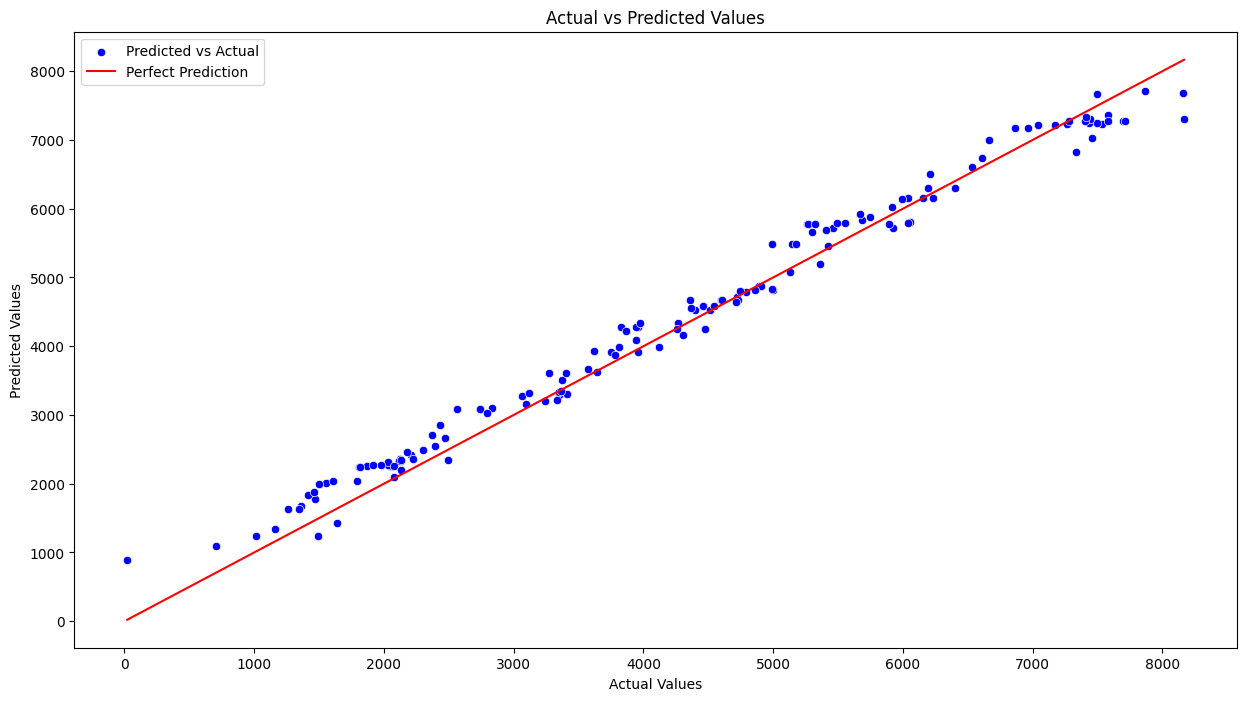

In [59]:
#Test the saved model
with open('bestmodel.pkl', 'rb') as file:
    saved_model = pkl.load(file)

fig, ax = plt.subplots(figsize = (15, 8))
sns.scatterplot(x=y_test, y=saved_model.predict(X_test), color='blue', label='Predicted vs Actual')
sns.lineplot(x=y_test, y=y_test, color='red', label='Perfect Prediction')

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.legend()

plt.show()

In [60]:
saved_model.feature_importances_

array([2.90249436e-04, 2.22107154e-05, 0.00000000e+00, 5.06439814e-04,
       1.82677461e-04, 0.00000000e+00, 1.07008685e-03, 2.97190039e-05,
       1.96459739e-01, 8.01438877e-01])

### Model Deployment

The bike rental prediction model was deployed using Flask to create a web application that allows users to input environmental and seasonal factors and receive real-time bike rental predictions. This deployment makes the model easily accessible and user-friendly for anyone needing rental forecasts.


<img src="image/Dashboard.PNG" width=6000 height=600 />